In [27]:
import sys, importlib, time
sys.path.append('../../')

from src.Modules.Utils.Imports import *
from src.Modules.Models.BuildBINNs import BINN
from src.Modules.Utils.ModelWrapper import ModelWrapper
from src.Modules.Utils.Gradient import Gradient

from get_params import get_heterog_LHC_params_vary_Padh_Ppull_alpha, get_adhesion_params_Padh_interpolation_Pm_fixed, get_adhesion_params_Pm_Padh_interpolation
import numpy.matlib as matlib

import src.Modules.Loaders.DataFormatter as DF

from src.DE_simulation import fickian_diffusion, Diffusion_eqn, simple_pulling_diffusion, simple_adhesion_diffusion, Heterogeneous_Diffusion_eqn
from scipy.integrate import odeint
import matplotlib.patches as mpatches

device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))

# helper functions
def to_torch(x):
    return torch.from_numpy(x).float().to(device)
def to_numpy(x):
    return x.detach().cpu().numpy()

def DE_sim(x, t, q, IC, Diffusion_function, PDE_type = "1d"):
    
    if PDE_type == "1d":
        sol = odeint(Diffusion_eqn, IC, t, args=(x, q, Diffusion_function))
    elif PDE_type == "heterogeneous":
        sol = odeint(Heterogeneous_Diffusion_eqn, IC, t, args=(x, q))
        sol = sol[:, :len(x)] + sol[:, len(x):]
    sol = sol.T
    
    return sol

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
fontsize = 24

def plot_sol_data(x,t,U,sol_MF=None,sol_BINN=None,sol_interp=None,zoom=None, filename=None, params=None):
    
    if zoom is None:
        fig, axes = plt.subplots(1,3,figsize=(18,6),layout='constrained')
        snapshots = [33,66,99]
    else:
        fig, axes = plt.subplots(1,4,figsize=(24,6),layout='constrained')
        snapshots = [33,66,99,99]

    count = 0
    for i in snapshots:
        if sol_MF is not None:
            axes[count].plot(x,sol_MF[:,i],"-", linewidth=8,  c = colors[0], label = "Mean-field PDE")
        if sol_BINN is not None:
            axes[count].plot(x,sol_BINN[:,i],"--",linewidth=5, c = colors[1], label = "BINN-guided PDE")
        if sol_interp is not None:
            axes[count].plot(x,sol_interp[:,i],".-",linewidth=5, c = colors[2], label = "Interpolated PDE")
        
        
        if i <= 75: 
            m = "o" 
            mcolor = "black"
        else: 
            m ="s"
            mcolor = (.4,.4,.4)
        axes[count].plot(x[::2],U[::2,i],m,color=mcolor,markersize=8,label="Data")

        axes[count].set_xlabel("Space ($x$)",fontsize=fontsize)
        if count ==0: axes[count].set_ylabel("Density",fontsize=fontsize)
        axes[count].set_title(f"t = {round(t[i],1)}",fontsize=fontsize)
        count+=1
    
    if "simple_pulling" in filename:
        title = "Pulling ABM, $r_m^{pull}$ = "+f"{params[0]}"+", $p_{pull}$ = " + f"{params[1]}"
    elif "simple_adhesion" in filename:
        title = "Adhesion ABM, $r_m^{adh}$ = "+f"{params[0]}"+", $p_{adh}$ = " + f"{params[1]}"
    elif "adhesion_pulling" in filename:
        title = ("Pulling & Adhesion ABM, $r_m^{pull}$ = "+f"{params[0]}"+
                 ", $r_m^{adh}$ = "+f"{params[1]}"+
                 ", $p_{pull}$ = " + f"{params[2]}"+
                 ", $p_{adh}$ = " + f"{params[3]}"+
                 r", $\alpha$ = " + f"{params[4]}")
    plt.suptitle(title,fontsize=fontsize)
    if zoom is not None:    
        #zoom = (x,y,dx,dy)
        x,y,dx,dy = zoom
        
        rect=mpatches.Rectangle((x,y),dx,dy, 
                        fill = False,
                        color = "black",
                        linewidth = 1)
        axes[2].add_patch(rect)
        
        axes[3].set_xlim([x,x+dx])
        axes[3].set_ylim([y,y+dy])
        axes[3].set_xlabel("")
        axes[3].set_ylabel("")
        axes[3].set_title("")
        axes[3].set_xticks([])
        axes[3].set_yticks([])
        
    if filename is not None:
        plt.savefig(f"../../results/figures/{filename}.png",format="png")
    
    return fig, axes
            
def load_model(binn_name, x, t, save_name):

    # instantiate BINN
    binn = BINN(binn_name,x, t).to(device)
    weight = '_best_val'
    
    # wrap model and load weights
    parameters = binn.parameters()
    model = ModelWrapper(
        model=binn,
        optimizer=None,
        loss=None,
        save_name=save_name)
    
    #model.save_name += '_' + binn.name + weight
    model.save_name += weight
    model.load(model.save_name + '_model', device=device)

    return model, binn            

def recover_binn_params(binn):
    # learned diffusion term
    def D(u):
        D = binn.diffusion(to_torch(u)[:, None])
        return to_numpy(D).reshape(-1)

    # learned growth term
    def G(u):
        r = binn.growth(to_torch(u)[:, None])
        return to_numpy(r).reshape(-1)  

    return D, G

def unique_inputs(inputs):
    x = np.unique(inputs[:,0])
    t = np.unique(inputs[:,1])
    return x,t


Device set to cpu


## Pulling ABM

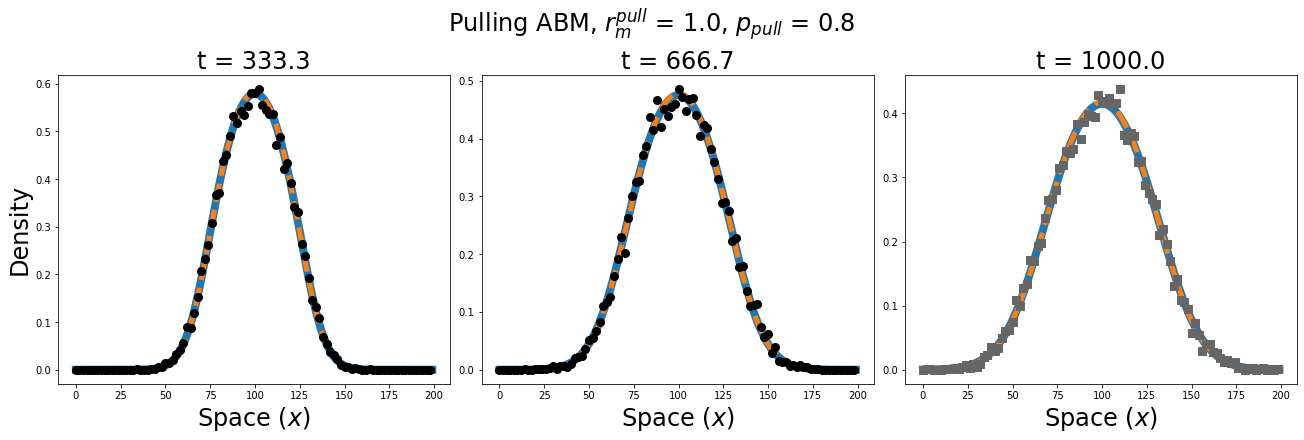

In [5]:
path = '../../data/'

#base parameters
Pm, Ppull = 1.0, 0.8
zoom = None

#Pm, Ppull = 0.9, 0.5
#zoom = None

params = (Pm, Ppull)
filename_header = f"simple_pulling_mean_25"

### BINN model information
save_folder = "../../Weights/"
model_name = 'DMLP'
weight = '_best_val'
surface_weight = 1.0
pde_weight = 1e4

file_name = f'{filename_header}_Pm_{Pm}_Pp_0.0_Ppull_{Ppull}' 

### load in ABM data
inputs, outputs, shape  = DF.load_ABM_data(path+file_name+".npy",plot=False)
outputs = outputs.reshape(shape)
x = np.unique(inputs[:,0])
t = np.unique(inputs[:,1])
IC = outputs[:,0]

#load in BINN data
binn_name  = f"{model_name}"
binn_save_name =  f"BINN_training_{binn_name}_{file_name}_pde_weight_{pde_weight}"
model,binn = load_model(binn_name=binn_name,save_name=save_folder + binn_save_name,x=x,t=t)
D_binn, G_binn = recover_binn_params(binn)

#previously-simulated BINN PDE
mat = np.load(f"../../results/PDE_sims/PDE_sim_DMLP_{file_name}_pde_weight_10000.0.npy",allow_pickle=True).item()
BINN_PDE = mat['U_sim']

q = [Pm/4, Ppull]
MF_PDE = DE_sim(x, t, q, IC, simple_pulling_diffusion)

fig, ax = plot_sol_data(x,t,outputs,MF_PDE,BINN_PDE, zoom=zoom,sol_interp=None,filename=f"data_prediction_{file_name}", params = params)

## Adhesion ABM

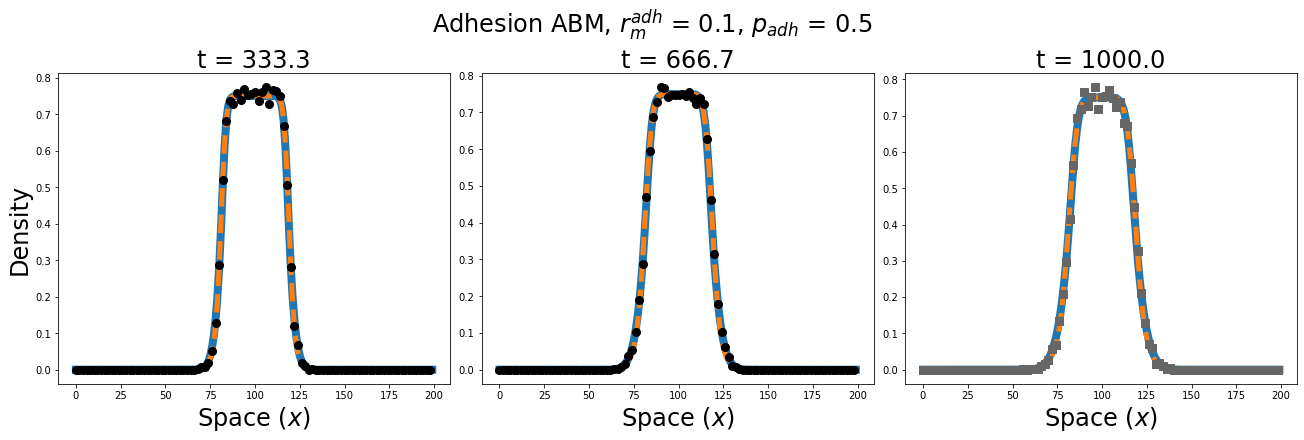

In [11]:
path = '../../data/'

#base parameters
#Pm, Padh = 1.0, 0.7
#zoom = (85, .55, 30,  .2)

Pm, Padh = 0.1, 0.5
zoom = None

params = (Pm, Padh)
filename_header = f"simple_adhesion_mean_25"

### BINN model information
save_folder = "../../Weights/"
model_name = 'DMLP'
weight = '_best_val'
surface_weight = 1.0
pde_weight = 1e4

file_name = f'{filename_header}_Pm_{Pm}_Pp_0.0_Padh_{Padh}' 

### load in ABM data
inputs, outputs, shape  = DF.load_ABM_data(path+file_name+".npy",plot=False)
outputs = outputs.reshape(shape)
x = np.unique(inputs[:,0])
t = np.unique(inputs[:,1])
IC = outputs[:,0]

#load in BINN data
binn_name  = f"{model_name}"
binn_save_name =  f"BINN_training_{binn_name}_{file_name}_pde_weight_{pde_weight}"
model,binn = load_model(binn_name=binn_name,save_name=save_folder + binn_save_name,x=x,t=t)
D_binn, G_binn = recover_binn_params(binn)

#previously-simulated BINN PDE
mat = np.load(f"../../results/PDE_sims/PDE_sim_DMLP_{file_name}_pde_weight_10000.0.npy",allow_pickle=True).item()
BINN_PDE = mat['U_sim']

if Padh > 0.75:
    MF_PDE = None
else:
    q = [Pm/4, Padh]
    MF_PDE = DE_sim(x, t, q, IC, simple_adhesion_diffusion)

fig, ax = plot_sol_data(x,t,outputs,MF_PDE,BINN_PDE, zoom=zoom,sol_interp=None,filename=f"data_prediction_{file_name}", params=params)

## Interpolated Adhesion

In [ ]:
def simulate_interpolant_PDE(params,f):
    
    Padh,Pm = params

    def interpolated_diffusion(u):
        U, PADH, PM = np.meshgrid( u , Padh, Pm, indexing = "ij")
        shape = U.shape
        try:
            new_points = np.array(list(zip(U.reshape(-1), 
                                           PADH.reshape(-1) )))
            D_mesh_new = f(new_points).reshape(shape)[:,0,0]
            D_mesh_new[D_mesh_new < 0] = 0
            return D_mesh_new
        except:
            new_points = np.array(list(zip(U.reshape(-1), 
                                           PADH.reshape(-1),
                                           PM.reshape(-1)   )))
            D_mesh_new = f(new_points).reshape(shape)[:,0,0]
            D_mesh_new[D_mesh_new < 0] = 0
            return D_mesh_new

    file_name = f'{filename_header}_Pm_{Pm}_Pp_{Pp}_Padh_{Padh}' 
    inputs, outputs, shape  = DF.load_ABM_data(path+file_name+".npy",plot=False)

    x,t = unique_inputs(inputs)

    U = outputs.reshape((len(x),-1))
    IC = U[:,0]

    t0 = time.time()
    sol = DE_sim(x, 
                 t, 
                 [], 
                 IC, 
                 Diffusion_function = interpolated_diffusion)
        
    tf = time.time()-t0
    
    return x, t, sol, U, tf

## Pulling Adhesion ABM

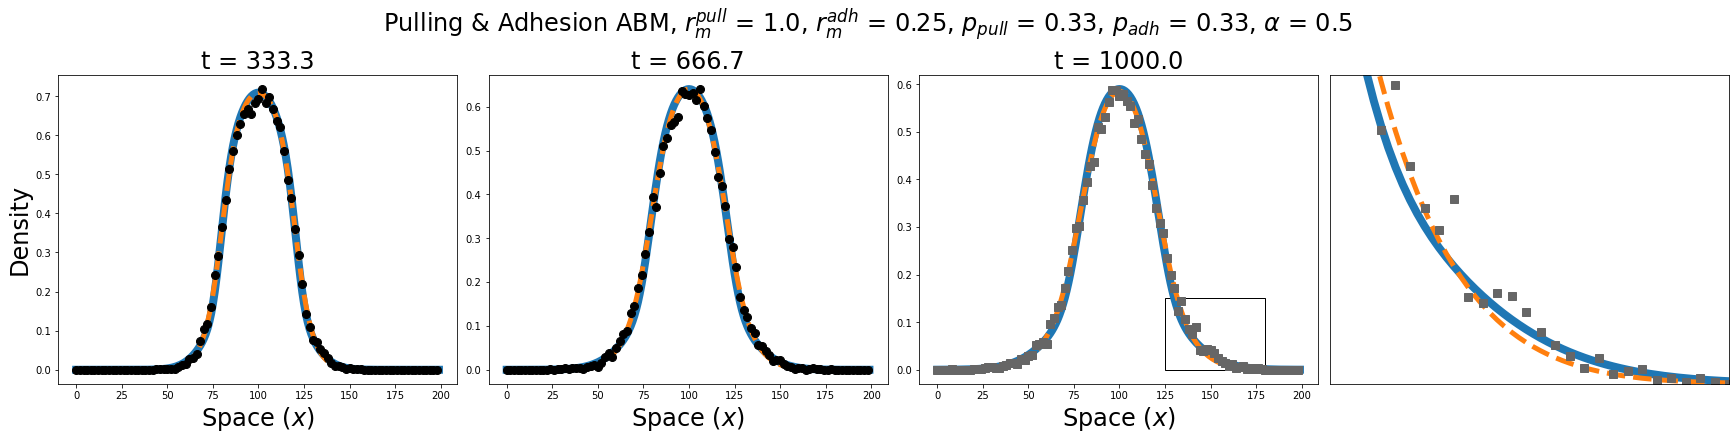

In [22]:
path = '../../data/'

#base parameters
PmH, PmP, Pp, Padh, Ppull, alpha = 0.25, 1.0, 0.0, 0.33, 0.33, 0.5

#modified param
#PmH = 0.1
#zoom = (85, .55, 30,  .1)
padh = 0.4
zoom = (125, 0, 180-125,  .15)

params = (PmP, PmH, Ppull, Padh, alpha)

filename_header = f"adhesion_pulling_mean_25"

### BINN model information
save_folder = "../../Weights/"
model_name = 'DMLP'
weight = '_best_val'
surface_weight = 1.0
pde_weight = 1e4

file_name = f'{filename_header}_PmH_{PmH}_PmP_{PmP}_Pp_{Pp}_Padh_{Padh}_Ppull_{Ppull}_alpha_{alpha}' 

### load in ABM data
inputs, outputs, shape  = DF.load_ABM_data(path+file_name+".npy",plot=False)
outputs = outputs.reshape(shape)
x = np.unique(inputs[:,0])
t = np.unique(inputs[:,1])
IC_mat = np.load(path+file_name+".npy",allow_pickle=True).item()
compartmental_data = IC_mat['compartments']
Hcomp, Pcomp = compartmental_data[0,:,:], compartmental_data[1,:,:]
comp_IC = np.hstack( (Hcomp[:,0], Pcomp[:,0]) )

#load in BINN data
binn_name  = f"{model_name}"
binn_save_name =  f"BINN_training_{binn_name}_{file_name}_pde_weight_{pde_weight}"
model,binn = load_model(binn_name=binn_name,save_name=save_folder + binn_save_name,x=x,t=t)
D_binn, G_binn = recover_binn_params(binn)

#previously-simulated BINN PDE
mat = np.load(f"../../results/PDE_sims/PDE_sim_DMLP_{file_name}_pde_weight_10000.0.npy",allow_pickle=True).item()
BINN_PDE = mat['U_sim']


q = [PmH/4, PmP/4, Padh, Ppull]
#MF_PDE = DE_sim(x, t, q, comp_IC, [], PDE_type = "heterogeneous")

fig, ax = plot_sol_data(x,t,outputs,MF_PDE,BINN_PDE, zoom=zoom,sol_interp=None,filename=f"data_prediction_{file_name}", params=params)

## Adhesion prediction (rmh fixed)

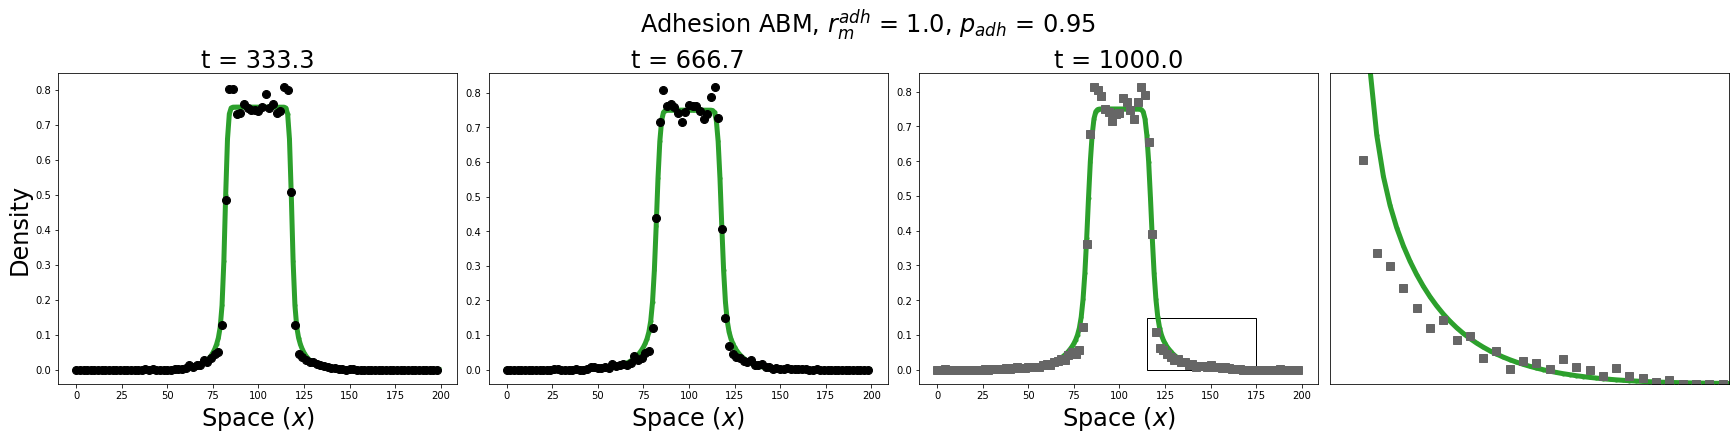

In [28]:
u_mesh = np.linspace(0, 1, 101)[:,None]
path = '../../data/'
mat = np.load("../../results/PDE_sims/adhesion_interpolant_Pm_fixed.npy",allow_pickle=True).item()
f = mat['f']

Padh = 0.95
Pm = 1.0
zoom = (115, 0, 60,  .15)

params = (Padh)
params_title = (Pm,Padh)

def interpolated_diffusion(u):

    param_mesh = matlib.repmat(params,len(u),1)
    sampled_points_mesh = np.hstack([u[:,None], param_mesh])
    D_mesh_new = f(sampled_points_mesh)
    D_mesh_new[D_mesh_new < 0] = 0

    return D_mesh_new

filename_header = f"simple_adhesion_mean_25"
file_name = f'{filename_header}_Pm_{Pm}_Pp_0.0_Padh_{Padh}' 
inputs, outputs, shape  = DF.load_ABM_data(path+file_name+".npy",plot=False)

x,t = unique_inputs(inputs)

outputs = outputs.reshape((len(x),-1))
IC = outputs[:,0]

sol = DE_sim(x, 
             t, 
             [], 
             IC, 
             Diffusion_function = interpolated_diffusion)

fig, ax = plot_sol_data(x,t,outputs,zoom=zoom,sol_interp = sol, filename=f"data_prediction_{file_name}", params = params_title)

## Adhesion prediction (over rmh and padh)

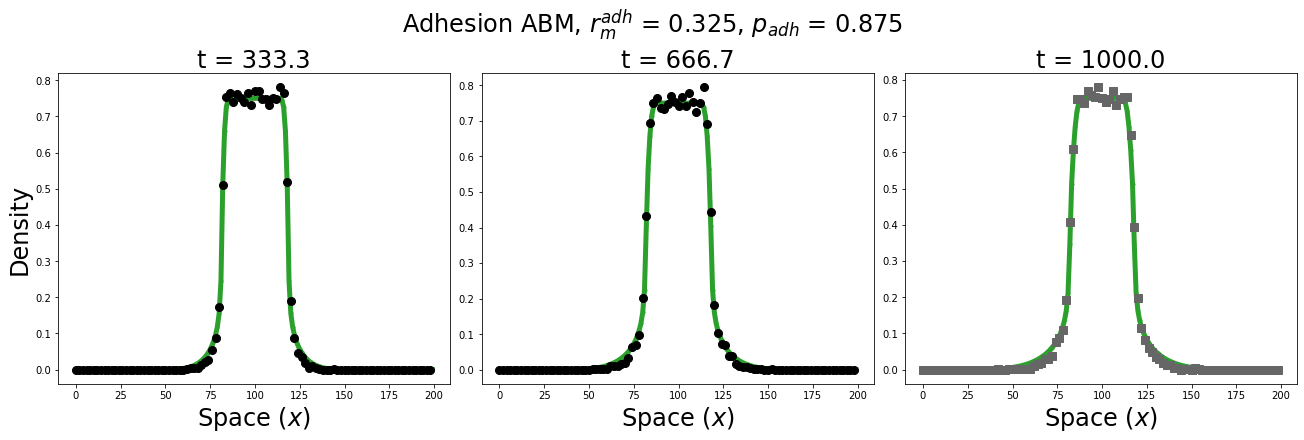

In [31]:
u_mesh = np.linspace(0, 1, 101)[:,None]
path = '../../data/'
mat = np.load("../../results/PDE_sims/adhesion_interpolant.npy",allow_pickle=True).item()
f = mat['f']

#Pm = 0.595
#Padh = 0.975
#zoom = None

Pm = 0.325
Padh = 0.875
zoom = None

params = (Padh,Pm)
params_title = (Pm,Padh)

def interpolated_diffusion(u):

    param_mesh = matlib.repmat(params,len(u),1)
    sampled_points_mesh = np.hstack([u[:,None], param_mesh])
    D_mesh_new = f(sampled_points_mesh)
    D_mesh_new[D_mesh_new < 0] = 0

    return D_mesh_new

filename_header = f"simple_adhesion_mean_25"
file_name = f'{filename_header}_Pm_{Pm}_Pp_0.0_Padh_{Padh}' 
inputs, outputs, shape  = DF.load_ABM_data(path+file_name+".npy",plot=False)

x,t = unique_inputs(inputs)

outputs = outputs.reshape((len(x),-1))
IC = outputs[:,0]

sol = DE_sim(x, 
             t, 
             [], 
             IC, 
             Diffusion_function = interpolated_diffusion)

fig, ax = plot_sol_data(x,t,outputs,zoom=zoom,sol_interp = sol, filename=f"data_prediction_{file_name}", params = params_title)

## Pulling & Adhesion prediction

In [16]:
u_mesh = np.linspace(0, 1, 101)[:,None]
path = '../../data/'
mat = np.load("../../results/PDE_sims/adhesion_pulling_interpolant.npy",allow_pickle=True).item()
f = mat['f']

params_new = np.round(get_heterog_LHC_params_vary_Padh_Ppull_alpha("Testing"),3)
n = 25

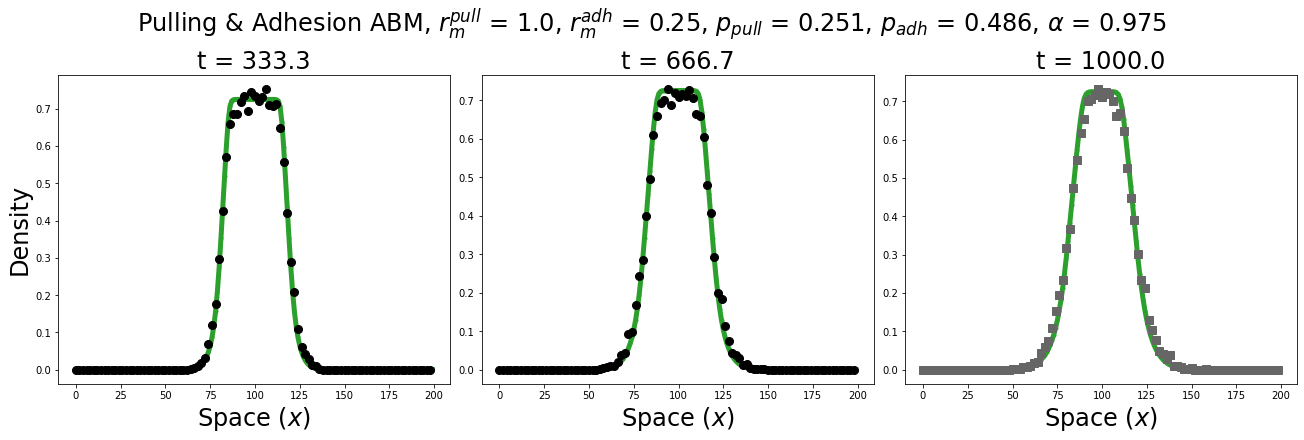

In [25]:
#6 gives the worst prediction
#5 gives the fourth worst prediction

params = params_new[5]
PmH, PmP, Pp, Padh, Ppull, alpha = params

params_title = (PmP, PmH, Ppull, Padh, alpha)

def interpolated_diffusion(u):

    param_mesh = matlib.repmat(params,len(u),1)
    sampled_points_mesh = np.hstack([u[:,None], param_mesh])
    D_mesh_new = f(sampled_points_mesh)
    D_mesh_new[D_mesh_new < 0] = 0

    return D_mesh_new

file_name = f'adhesion_pulling_mean_{n}_PmH_{PmH}_PmP_{PmP}_Pp_{Pp}_Padh_{Padh}_Ppull_{Ppull}_alpha_{alpha}'
inputs, outputs, shape  = DF.load_ABM_data(path+file_name+".npy",plot=False)

x,t = unique_inputs(inputs)

outputs = outputs.reshape((len(x),-1))
IC = outputs[:,0]

sol = DE_sim(x, 
             t, 
             [], 
             IC, 
             Diffusion_function = interpolated_diffusion)

fig, ax = plot_sol_data(x,t,outputs,sol_interp = sol, filename=f"data_prediction_{file_name}", params = params_title)

## Make legend

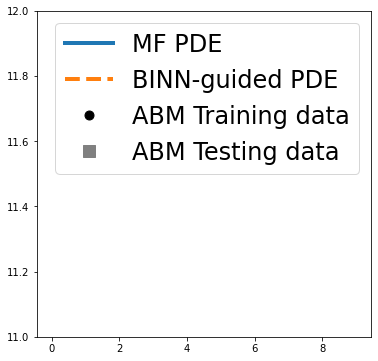

In [15]:
fig, axes = plt.subplots(1,1,figsize=(6,6))
i = 0
axes.plot(np.arange(10),np.arange(10),"-", linewidth=4,  c = colors[0], 
          label = "MF PDE")
axes.plot(np.arange(10),np.arange(10),"--", linewidth=4,  c = colors[1], 
          label = "BINN-guided PDE")
#axes.plot(np.arange(10),np.arange(10),"b-", linewidth=4,  c = colors[3], 
#          label = "MF PDE")


m = "o" 
mcolor = "black"
axes.plot(np.arange(10),np.arange(10),".",color="k",markersize=18,label="ABM Training data")
m ="s"
mcolor = (.4,.4,.4)
axes.plot(np.arange(10),np.arange(10),"s",color="gray",markersize=12,label="ABM Testing data")
axes.set_ylim([11,12])

plt.legend(fontsize=24)

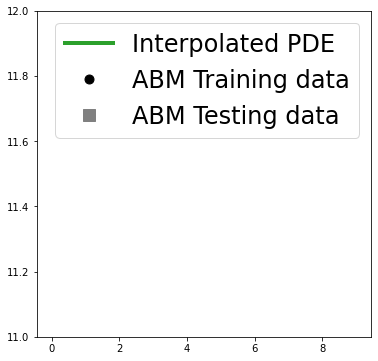

In [26]:
fig, axes = plt.subplots(1,1,figsize=(6,6))
i = 0
axes.plot(np.arange(10),np.arange(10),"-", linewidth=4,  c = colors[2], 
          label = "Interpolated PDE")
#axes.plot(np.arange(10),np.arange(10),"b-", linewidth=4,  c = colors[3], 
#          label = "MF PDE")


m = "o" 
mcolor = "black"
axes.plot(np.arange(10),np.arange(10),".",color="k",markersize=18,label="ABM Training data")
m ="s"
mcolor = (.4,.4,.4)
axes.plot(np.arange(10),np.arange(10),"s",color="gray",markersize=12,label="ABM Testing data")
axes.set_ylim([11,12])

plt.legend(fontsize=24)